# Exploratory Data Analysis

## Content
1. [Data imports](#imports)
2. [exploring the data structure](#structure)
3. [Up- & Downsampling](#sampling)
4. [data structure after SMOTE Upsampling](#new-structure)
5. [Regression Coefficient / Confidence Intervals](#regression)
6. [Correlation Matrix](#matrix)
7. [save to csv](#save)

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.metrics import * 
from sklearn.utils import resample
import matplotlib.colors as mcolors
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

<a id='imports'></a>
## Data imports

In [78]:
df = pd.read_csv("files/fo_swiss.csv")
abilities = pd.read_csv("files/onet_abilities.csv")
skills = pd.read_csv("files/onet_skills.csv")
not_automatable = [item[0] for item in pd.read_csv("files/not_automatable.csv").values.tolist()]

print(df.shape[0])
df.head(5)

326


,isco08,Name_de,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,...,a45,a46,a47,a48,a49,a50,a51,a52,fo_probability,fo_computerisation
0,2655,Schauspieler,2,0.72,0.72,0.69,0.69,0.50,0.50,0.50,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.370,na
1,2612,Richter,2,0.81,0.75,0.81,0.72,0.81,0.66,0.56,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.400,na
2,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3,0.69,0.66,0.66,0.47,0.72,0.53,0.53,...,0.0,0.0,0.25,0.28,0.19,0.03,0.03,0.0,0.240,na
3,2120,"Mathematiker, Aktuare und Statistiker",2,0.81,0.72,0.75,0.50,0.81,0.53,0.50,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.035,na
4,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1,0.69,0.75,0.78,0.75,0.75,0.56,0.63,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.015,na


<a id='structure'></a>
## Exploring the data structure

In [79]:
# drop columns
skills = skills.drop(columns=["id"])
abilities = abilities.drop(columns=["id"])

In [80]:
# rename columns
skills = skills.rename(columns={"name": "skill", "description": "skill_description"})
abilities = abilities.rename(columns={"name": "ability", "description": "ability_description"})

In [81]:
# Add a letter in front of 'id' column
skills['skill_id'] = 's' + skills['skill_id'].astype(str)
abilities['ability_id'] = 'a' + abilities['ability_id'].astype(str)

df.head(2)

,isco08,Name_de,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,...,a45,a46,a47,a48,a49,a50,a51,a52,fo_probability,fo_computerisation
0,2655,Schauspieler,2,0.72,0.72,0.69,0.69,0.50,0.50,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37,na
1,2612,Richter,2,0.81,0.75,0.81,0.72,0.81,0.66,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,na


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 92 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   isco08              326 non-null    int64  
 1   Name_de             326 non-null    object 
 2   Berufshauptgruppe   326 non-null    int64  
 3   s1                  326 non-null    float64
 4   s2                  326 non-null    float64
 5   s3                  326 non-null    float64
 6   s4                  326 non-null    float64
 7   s5                  326 non-null    float64
 8   s6                  326 non-null    float64
 9   s7                  326 non-null    float64
 10  s8                  326 non-null    float64
 11  s9                  326 non-null    float64
 12  s10                 326 non-null    float64
 13  s11                 326 non-null    float64
 14  s12                 326 non-null    float64
 15  s13                 326 non-null    float64
 16  s14     

In [83]:
df.describe().round(2)

,isco08,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,s8,...,a44,a45,a46,a47,a48,a49,a50,a51,a52,fo_probability
count,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,...,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00
mean,4931.37,4.64,0.59,0.62,0.63,0.53,0.60,0.58,0.52,0.53,...,0.39,0.10,0.11,0.23,0.26,0.21,0.11,0.16,0.14,0.43
std,2580.44,2.59,0.14,0.13,0.12,0.12,0.12,0.11,0.09,0.13,...,0.15,0.12,0.13,0.20,0.22,0.19,0.13,0.15,0.14,0.39
min,1112.00,1.00,0.25,0.28,0.25,0.25,0.31,0.22,0.25,0.22,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2634.25,2.00,0.50,0.50,0.50,0.44,0.50,0.50,0.47,0.44,...,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03
50%,4311.50,4.00,0.56,0.66,0.66,0.50,0.60,0.53,0.50,0.50,...,0.36,0.03,0.03,0.22,0.25,0.19,0.03,0.15,0.13,0.36
75%,7322.75,7.00,0.72,0.75,0.75,0.63,0.72,0.69,0.56,0.63,...,0.50,0.19,0.24,0.41,0.44,0.35,0.22,0.25,0.25,0.84
max,9629.00,9.00,0.94,0.94,0.97,0.81,0.81,0.78,0.75,0.78,...,0.91,0.60,0.72,0.78,0.81,0.97,0.47,0.75,0.63,0.99


In [84]:
# replace na with 0
df["fo_computerisation"] =  pd.to_numeric(df["fo_computerisation"], errors='coerce').fillna(0).astype(int)  # this will convert na to 0, which is wrong. the issue is solved later on

In [85]:
#Get Number per class 
freq = df['fo_computerisation'].value_counts()
print(freq)

fo_computerisation
0    314
1     12
Name: count, dtype: int64


In [86]:
# calculate fo_computerisation based on 'df_probability'
df['fo_computerisation'] = df['fo_probability'].apply(lambda x: 1 if x >= 0.5 else 0)

In [87]:
#Get Number per class 
freq = df['fo_computerisation'].value_counts()
print(freq)

fo_computerisation
0    178
1    148
Name: count, dtype: int64


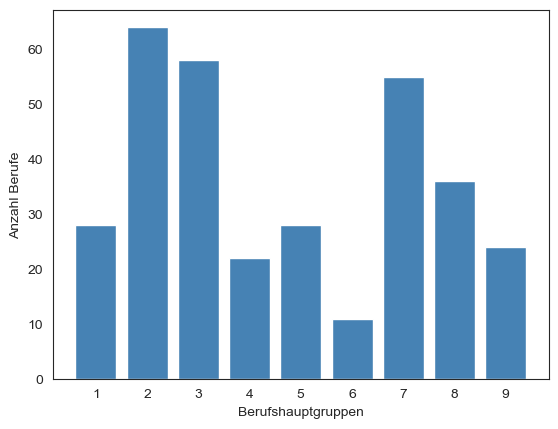

In [88]:
# Get number per class and sort by index
freq = df['Berufshauptgruppe'].value_counts().sort_index()

# Create a bar chart
plt.bar(range(len(freq)), freq.values, color="#4682B4")

# Set title, x-label, y-label, and x-ticks
plt.ylabel('Anzahl Berufe', fontsize = 10)
plt.xlabel('Berufshauptgruppen', fontsize = 10)
plt.xticks(range(len(freq)), freq.index)

# Show the figure
plt.show()

In [89]:
# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Calculate correlation
corr = df_numeric.corr()

# Display the correlation matrix
corr

,isco08,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,s8,...,a45,a46,a47,a48,a49,a50,a51,a52,fo_probability,fo_computerisation
isco08,1.000000,0.998287,-0.780094,-0.724832,-0.768921,-0.657392,-0.704797,-0.510884,-0.502370,-0.679214,...,0.551850,0.561929,0.676531,0.669807,0.623415,0.557115,0.496304,0.649642,0.510758,0.494887
Berufshauptgruppe,0.998287,1.000000,-0.785612,-0.733018,-0.775674,-0.664497,-0.707131,-0.511340,-0.506091,-0.679665,...,0.554762,0.564717,0.683692,0.676154,0.629064,0.560632,0.501174,0.653424,0.518262,0.503570
s1,-0.780094,-0.785612,1.000000,0.789472,0.849349,0.655073,0.836534,0.609810,0.613115,0.781304,...,-0.393883,-0.440090,-0.588218,-0.579570,-0.540124,-0.402196,-0.384058,-0.630015,-0.512661,-0.497289
s2,-0.724832,-0.733018,0.789472,1.000000,0.908991,0.834895,0.754310,0.599137,0.642778,0.706376,...,-0.361852,-0.393288,-0.630389,-0.606298,-0.535363,-0.395728,-0.337968,-0.575574,-0.557475,-0.548277
s3,-0.768921,-0.775674,0.849349,0.908991,1.000000,0.789313,0.777944,0.592369,0.637421,0.729087,...,-0.375216,-0.408926,-0.611800,-0.592960,-0.524761,-0.406229,-0.367260,-0.566921,-0.563570,-0.545791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a50,0.557115,0.560632,-0.402196,-0.395728,-0.406229,-0.365147,-0.208847,-0.095499,-0.188122,-0.247600,...,0.918138,0.910412,0.759231,0.784532,0.802498,1.000000,0.835231,0.665827,0.103014,0.154802
a51,0.496304,0.501174,-0.384058,-0.337968,-0.367260,-0.326187,-0.179069,-0.080187,-0.157205,-0.180893,...,0.881171,0.912271,0.684001,0.714539,0.774746,0.835231,1.000000,0.657659,0.057525,0.092507
a52,0.649642,0.653424,-0.630015,-0.575574,-0.566921,-0.472795,-0.416801,-0.218547,-0.350913,-0.446690,...,0.665158,0.724730,0.752964,0.787220,0.799037,0.665827,0.657659,1.000000,0.228484,0.253942
fo_probability,0.510758,0.518262,-0.512661,-0.557475,-0.563570,-0.540139,-0.616052,-0.534419,-0.475254,-0.557876,...,0.071696,0.103256,0.289879,0.246624,0.204038,0.103014,0.057525,0.228484,1.000000,0.950052


In [90]:
cov = df_numeric.cov()
cov

,isco08,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,s8,...,a45,a46,a47,a48,a49,a50,a51,a52,fo_probability,fo_computerisation
isco08,6.658669e+06,6664.048334,-276.964797,-233.957337,-237.945667,-200.748870,-210.191839,-139.673673,-122.864516,-222.716112,...,164.895488,189.837509,356.604117,382.399647,298.976780,179.784959,194.029221,235.949105,514.812848,636.781463
Berufshauptgruppe,6.664048e+03,6.692336,-0.279628,-0.237197,-0.240641,-0.203431,-0.211420,-0.140151,-0.124087,-0.223426,...,0.166184,0.191261,0.361289,0.386998,0.302447,0.181377,0.196428,0.237922,0.523696,0.649589
s1,-2.769648e+02,-0.279628,0.018931,0.013587,0.014014,0.010666,0.013302,0.008889,0.007995,0.013660,...,-0.006275,-0.007927,-0.016532,-0.017643,-0.013812,-0.006920,-0.008006,-0.012201,-0.027552,-0.034118
s2,-2.339573e+02,-0.237197,0.013587,0.015646,0.013635,0.012359,0.010905,0.007940,0.007620,0.011228,...,-0.005241,-0.006441,-0.016107,-0.016779,-0.012446,-0.006190,-0.006405,-0.010133,-0.027238,-0.034198
s3,-2.379457e+02,-0.240641,0.014014,0.013635,0.014382,0.011202,0.010782,0.007526,0.007245,0.011110,...,-0.005210,-0.006420,-0.014987,-0.015733,-0.011696,-0.006092,-0.006673,-0.009569,-0.026399,-0.032638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a50,1.797850e+02,0.181377,-0.006920,-0.006190,-0.006092,-0.005404,-0.003019,-0.001265,-0.002230,-0.003935,...,0.013296,0.014906,0.019395,0.021707,0.018652,0.015640,0.015825,0.011720,0.005032,0.009653
a51,1.940292e+02,0.196428,-0.008006,-0.006405,-0.006673,-0.005848,-0.003135,-0.001287,-0.002257,-0.003483,...,0.015459,0.018095,0.021168,0.023951,0.021815,0.015825,0.022954,0.014024,0.003404,0.006989
a52,2.359491e+02,0.237922,-0.012201,-0.010133,-0.009569,-0.007875,-0.006780,-0.003259,-0.004681,-0.007989,...,0.010841,0.013355,0.021649,0.024514,0.020902,0.011720,0.014024,0.019811,0.012562,0.017823
fo_probability,5.148128e+02,0.523696,-0.027552,-0.027238,-0.026399,-0.024968,-0.027811,-0.022117,-0.017594,-0.027690,...,0.003243,0.005280,0.023129,0.021313,0.014812,0.005032,0.003404,0.012562,0.152574,0.185046


<Axes: xlabel='fo_probability'>

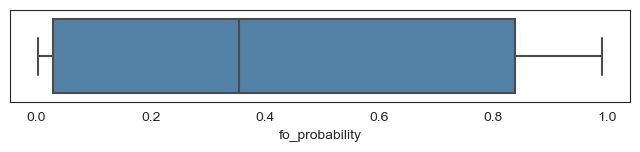

In [91]:
# boxplot of probabilities of computerisation
plt.figure(figsize=(8,1.2))
sns.set_style("white")
sns.boxplot(x=df['fo_probability'], color="#4682B4")

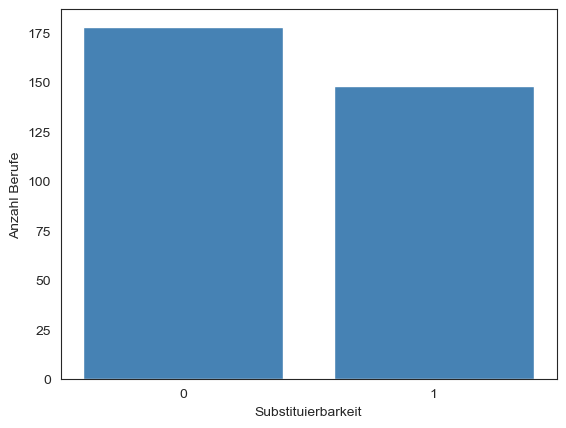

In [92]:
# Get number per class
freq = df['fo_computerisation'].value_counts()

# Create a bar chart
plt.bar(freq.index, freq.values, color="#4682B4")
# plt.title('Substituierbarkeit nach Osborne & Frey (2013)')
plt.ylabel('Anzahl Berufe', fontsize = 10)
plt.xticks(freq.index)
plt.xlabel('Substituierbarkeit', fontsize = 10)
plt.show()

<a id='sampling'></a>
## Up- & Downsampling

In [93]:
df_numeric = df.drop(columns=['Name_de'])

In [94]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_numeric.drop('fo_computerisation', axis=1), df_numeric['fo_computerisation'], test_size=0.2, random_state=42)

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)

AUC: 1.00


### calculate minority and majority class automaitcally

In [95]:
# Get the counts of each class
class_counts = df_numeric['fo_computerisation'].value_counts()

# Identify majority and minority classes
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separate majority and minority classes
df_majority = df_numeric[df['fo_computerisation'] == majority_class]
df_minority = df_numeric[df['fo_computerisation'] == minority_class]

### SMOTE

In [96]:
# Assuming your dataframe is df and 'fo_computerisation' is the target column
X = df_numeric.select_dtypes(include=[np.number]).drop('fo_computerisation', axis=1)
y = df_numeric['fo_computerisation']

oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

counter = Counter(y)
print(counter)

df_smote = pd.concat([pd.DataFrame(X), pd.DataFrame(y, columns=['fo_computerisation'])], axis=1)

Counter({0: 178, 1: 178})


In [97]:
# calculate "fo_computerisation" based on 'df_probability' to make sure SMOTE didn't mess this up
df_smote['fo_computerisation'] = df_smote['fo_probability'].apply(lambda x: 1 if x >= 0.5 else 0)

In [98]:
# Get Amount per class
freq = df_smote['fo_computerisation'].value_counts()
print(freq)

fo_computerisation
0    178
1    178
Name: count, dtype: int64


In [99]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_smote.drop('fo_computerisation', axis=1), df_smote['fo_computerisation'], test_size=0.2, random_state=42)

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)

AUC: 1.00


### Upsampling

In [100]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=53) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.fo_computerisation.value_counts()

fo_computerisation
0    178
1    178
Name: count, dtype: int64

In [101]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_upsampled.drop('fo_computerisation', axis=1), df_upsampled['fo_computerisation'], test_size=0.2, random_state=42)

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)

AUC: 0.99


### Downsampling

In [102]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=df_minority.shape[0],  # to match minority class
                                   random_state=42) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.fo_computerisation.value_counts()

fo_computerisation
0    148
1    148
Name: count, dtype: int64

In [103]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_downsampled.drop('fo_computerisation', axis=1), df_downsampled['fo_computerisation'], test_size=0.2, random_state=53)

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)

AUC: 1.00


<a id='new-structure'></a>
## Data structure after SMOTE Upsampling

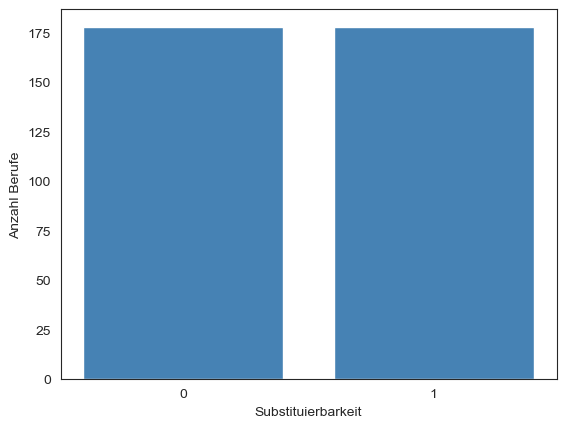

In [104]:
# Get number per class
freq = df_smote['fo_computerisation'].value_counts()

# Create a bar chart
plt.bar(freq.index, freq.values, color="#4682B4")
# plt.title('Substituierbarkeit nach Osborne & Frey (2013)')
plt.ylabel('Anzahl Berufe', fontsize = 10)
plt.xticks(freq.index)
plt.xlabel('Substituierbarkeit', fontsize = 10)
plt.show()

<Axes: xlabel='fo_probability'>

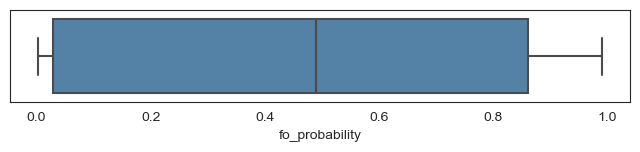

In [105]:
# boxplot of probabilities of computerisation
plt.figure(figsize=(8,1.2))
sns.set_style("white")
sns.boxplot(x=df_smote['fo_probability'], color="#4682B4")

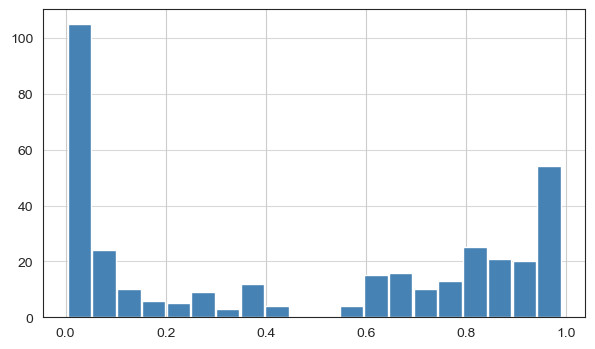

In [106]:
# Plot Histogram
fig = plt.figure(figsize=(7,4))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
n, bins, patches = plt.hist(x=df_smote['fo_probability'], 
                            bins=20, 
                            color="#4682B4",
                            rwidth=0.95
                   )
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(axis='y', alpha=0.75)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

/opt/anaconda3/envs/bachelorarbeit/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


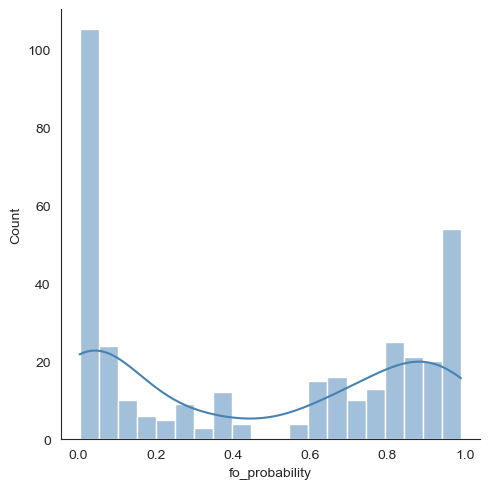

In [107]:
sns.displot(df_smote['fo_probability'], bins=20, color="#4682B4", kde=True)

<a id='regression'></a>
## Regression Coefficient / Confidence Intervals

/var/folders/ms/0wqr6tr506lfp142wmz0qph40000gn/T/ipykernel_3937/1369965362.py:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(-0.01, 0.01, color='#ff0000', alpha=0.3, edgecolor='none')
/var/folders/ms/0wqr6tr506lfp142wmz0qph40000gn/T/ipykernel_3937/1369965362.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(0.011, 0.05, color='#00FF00', alpha=0.1, edgecolor='none')
/var/folders/ms/0wqr6tr506lfp142wmz0qph40000gn/T/ipykernel_3937/1369965362.py:32: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(-0.05, -0.011, color='#00FF00', alpha=0.1, edgecolor='none')


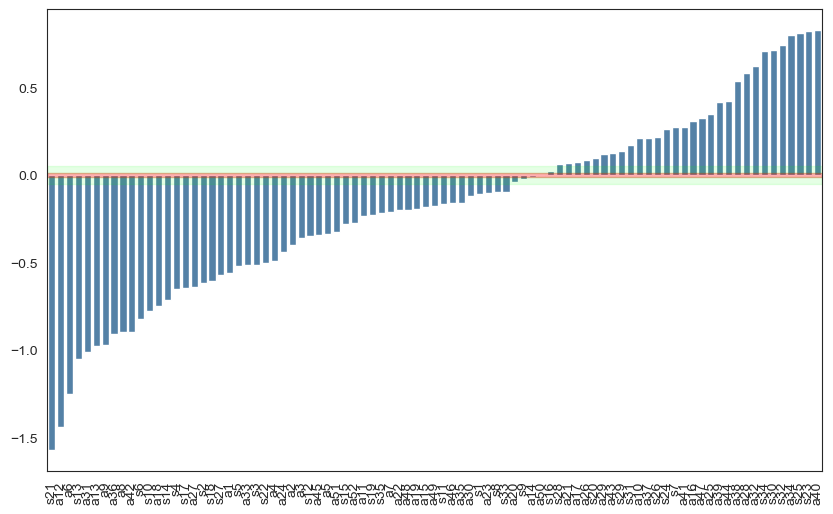

In [108]:
# Select columns that start with 's' or 'a' and the 'fo_probability' column
df_selected = df_smote.filter(regex='^(s|a|fo_computerisation)')

# Define the dependent variable
y = df_selected['fo_computerisation']

# Define the independent variables
X = df_selected.drop('fo_computerisation', axis=1)

# Fit the model
model = LogisticRegression()
model.fit(X, y)

intercept = model.intercept_

# Get the regression coefficients
coefficients = pd.Series(model.coef_[0], index=X.columns)

# Sort the coefficients
coefficients = coefficients.sort_values()

# Create a bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=coefficients.index, y=coefficients.values, color="#4682B4")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Konfidenzintervall 99%
plt.axhspan(-0.01, 0.01, color='#ff0000', alpha=0.3, edgecolor='none')

# Konfidenzintervall 95%
plt.axhspan(0.011, 0.05, color='#00FF00', alpha=0.1, edgecolor='none')
plt.axhspan(-0.05, -0.011, color='#00FF00', alpha=0.1, edgecolor='none')

plt.show()

<a id='save'></a>
## Save to csv

In [109]:
# Extract coefficients outside the 95% confidence interval
coefficients_outside_95 = coefficients[(coefficients < -0.05) | (coefficients > 0.05)].round(4)

# Extract coefficients outside the 99% confidence interval
coefficients_outside_99 = coefficients[(coefficients < -0.01) | (coefficients > 0.01)].round(4)

In [110]:
# Create a dataframe from the coefficients outside the 95% and 99% confidence intervals with headers
coefficients_outside_95 = pd.DataFrame(list(coefficients_outside_95.items()), columns=['id', 'coefficient'])
coefficients_outside_99 = pd.DataFrame(list(coefficients_outside_99.items()), columns=['id', 'coefficient'])

# Merge skills dataframe with coefficients
coefficients_outside_95 = coefficients_outside_95.merge(skills, left_on='id', right_on='skill_id', how='left')
coefficients_outside_99 = coefficients_outside_99.merge(skills, left_on='id', right_on='skill_id', how='left')

# Merge abilities dataframe with coefficients
coefficients_outside_95 = coefficients_outside_95.merge(abilities, left_on='id', right_on='ability_id', how='left')
coefficients_outside_99 = coefficients_outside_99.merge(abilities, left_on='id', right_on='ability_id', how='left')

# remove unnecessary columns
coefficients_outside_95 = coefficients_outside_95.drop(columns=['skill_id', 'ability_id'])
coefficients_outside_99 = coefficients_outside_99.drop(columns=['skill_id', 'ability_id'])

In [111]:
# Merge skill and skill description
coefficients_outside_95['skill'] = coefficients_outside_95['skill'].fillna(coefficients_outside_95['ability'])
coefficients_outside_95["skill_description"] = coefficients_outside_95["skill_description"].fillna(coefficients_outside_95["ability_description"])

coefficients_outside_99['skill'] = coefficients_outside_99['skill'].fillna(coefficients_outside_99['ability'])
coefficients_outside_99["skill_description"] = coefficients_outside_99["skill_description"].fillna(coefficients_outside_99["ability_description"])

# Now you can drop the abilities
coefficients_outside_95 = coefficients_outside_95.drop(columns=['ability_description', 'ability'])
coefficients_outside_99 = coefficients_outside_99.drop(columns=['ability_description', 'ability'])

In [112]:
# Save the dataframes to csv files
coefficients_outside_95.reset_index().rename(columns={'index': 'Variable', 0: 'Coefficient'}).sort_values('coefficient').drop(columns=["Variable"]).to_csv('files/coefficients_outside_95.csv', index=False)
coefficients_outside_99.reset_index().rename(columns={'index': 'Variable', 0: 'Coefficient'}).sort_values('coefficient').drop(columns=["Variable"]).to_csv('files/coefficients_outside_99.csv', index=False)
df_smote.to_csv('files/fo_smote.csv', index=False)
pd.DataFrame([intercept], columns=['intercept']).to_csv('files/intercept_not_normalized.csv', index=False)

In [113]:
cols_to_keep = not_automatable
cols_to_keep.extend(['fo_probability', 'fo_computerisation'])

# Drop the other columns
df_smote = df_smote[cols_to_keep]

# Display the first few rows of the DataFrame
df_smote.head(5)

,s15,s8,s31,s26,s24,a12,a13,s4,s27,a5,fo_probability,fo_computerisation
0,0.38,0.47,0.0,0.00,0.06,0.47,0.47,0.69,0.00,0.72,0.370,0
1,0.56,0.72,0.0,0.00,0.19,0.78,0.81,0.72,0.00,0.81,0.400,0
2,0.38,0.63,0.5,0.41,0.28,0.72,0.72,0.47,0.28,0.75,0.240,0
3,0.44,0.75,0.0,0.00,0.22,0.75,0.78,0.50,0.00,0.75,0.035,0
4,0.53,0.63,0.0,0.03,0.19,0.72,0.63,0.75,0.00,0.75,0.015,0


<a id='matrix'></a>
## Correlation Matrix

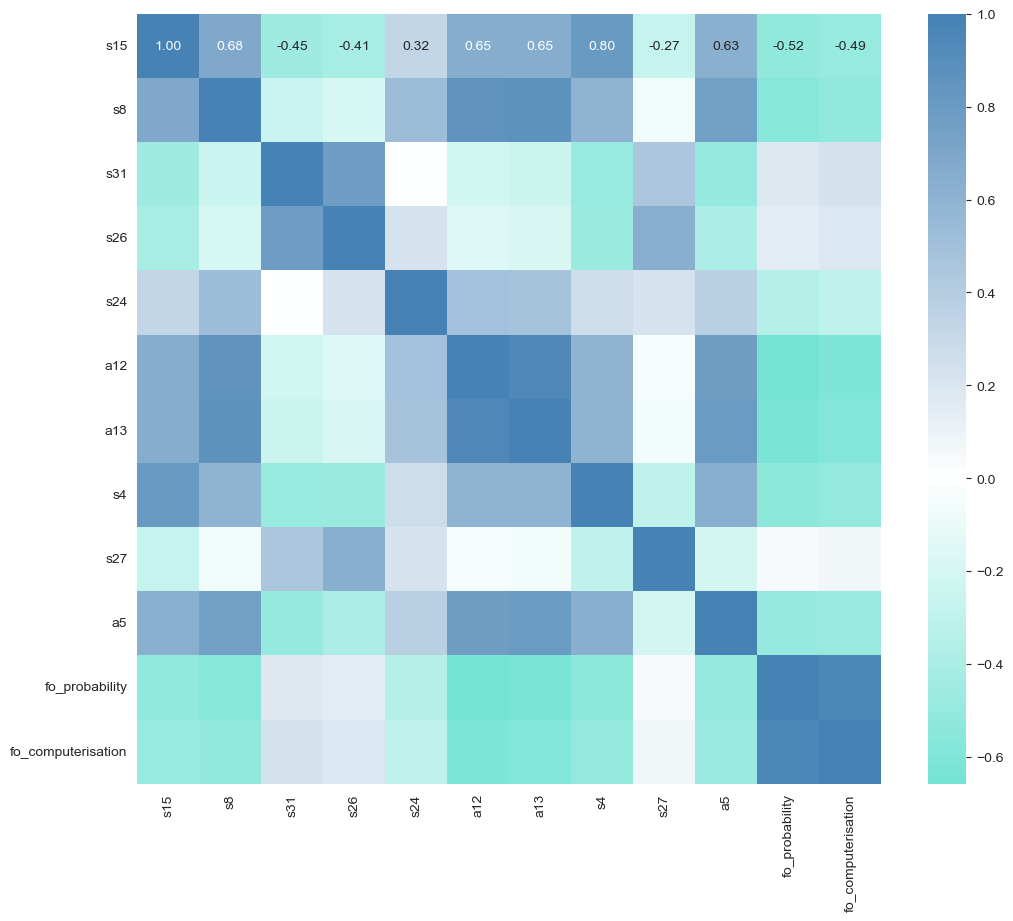

In [114]:
# Calculate the correlation matrix
corr_matrix = df_smote.corr()

# Create a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#2dd4bf", "white", "#4682B4"])

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, center=0)

# Show the plot
plt.show()